# 3. Sentiment Classification, Analysis and Visualization

In [244]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import nbimporter
import matplotlib.pyplot as plt
import nltk
from afinn import Afinn
import analysis as ana
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import joblib
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.utils import resample

from ipynb.fs.full.analysis import clean_data
from ipynb.fs.full.analysis import column_to_text

# Download WordNet and other necessary resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [245]:
# Load data (comments)
comments = pd.read_csv("./data/elon_comments.csv", sep = ",")
print(comments.shape)
comments.head()

(2873, 4)


,User,Comment,Time,Likes
0,@raedjah6417,NaN,4 years ago,4.6K
1,@jg63776,I like how he always says “we” . A real leader,4 years ago,171
2,@thatguynicky1979,Communism intensifies,4 years ago,101
3,@ibeezisi3847,"We, as in ALL of the geniuses and innovators h...",4 years ago,12
4,@leyren2606,Very good observation! I hope to imbibe that m...,4 years ago (edited),32


In [246]:
# Clean data with function from "analysis.ipynb"
clean_comments = clean_data(comments)
comments['Year'] = 2024.5 - comments["n_days_ago"]// 365
clean_comments.head()

c:\Users\Thy\Downloads\Abgabe_Projekt_Thu_Julius\Abgabe_Projekt_Thu_Julius\Abgabe_Projekt_Thu_Julius\Project\analysis.ipynb:102: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  "<table border=\"1\" class=\"dataframe\">\n",


,User,Comment,Likes,n_days_ago,yt_timestamp,Year
0,raedjah6417,,4600,1460,4 years ago,2020.5
1,jg63776,like always say “ ” real leader,171,1460,4 years ago,2020.5
2,thatguynicky1979,communism intensifies,101,1460,4 years ago,2020.5
3,ibeezisi3847,genius innovator employ,12,1460,4 years ago,2020.5
4,leyren2606,good observation hope imbibe often,32,1460,4 years ago,2020.5


## 3.1 NRC Analysis

In [247]:
with open(r"nrc_emotion_lexicon/" + "anger" + "-NRC-Emotion-Lexicon.txt","r") as file:
    words = [line.strip().split()[0] for line in file.readlines()]
    
len(words)

14154

In [248]:
lexicon = {}
emotions = ["anger","anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"]

for emotion in emotions:
    with open(r"nrc_emotion_lexicon/" + emotion + "-NRC-Emotion-Lexicon.txt","r") as file:
        words = [line.strip().split()[0] for line in file.readlines() if line.strip().split()[1] == "1"]
    
    lexicon[emotion] = words

In [249]:
# Function maps text to the nrc sentiments
def map_text_to_emotion(text):
    emotion_counter = {emotion: 0 for emotion in emotions}

    tokens = text.split()

    for word in tokens:
        for emotion in emotions:
            if word in lexicon[emotion]:
                emotion_counter[emotion] += 1

    return emotion_counter

In [250]:
map_text_to_emotion("The only product elon makes is shit and bad")

{'anger': 2,
 'anticipation': 0,
 'disgust': 2,
 'fear': 1,
 'joy': 0,
 'negative': 2,
 'positive': 0,
 'sadness': 1,
 'surprise': 0,
 'trust': 0}

In [251]:
clean_text = column_to_text(clean_comments.Comment)
emotion_count = map_text_to_emotion(clean_text)
emotion_count

{'anger': 710,
 'anticipation': 1499,
 'disgust': 447,
 'fear': 957,
 'joy': 1254,
 'negative': 1615,
 'positive': 3217,
 'sadness': 768,
 'surprise': 645,
 'trust': 2026}

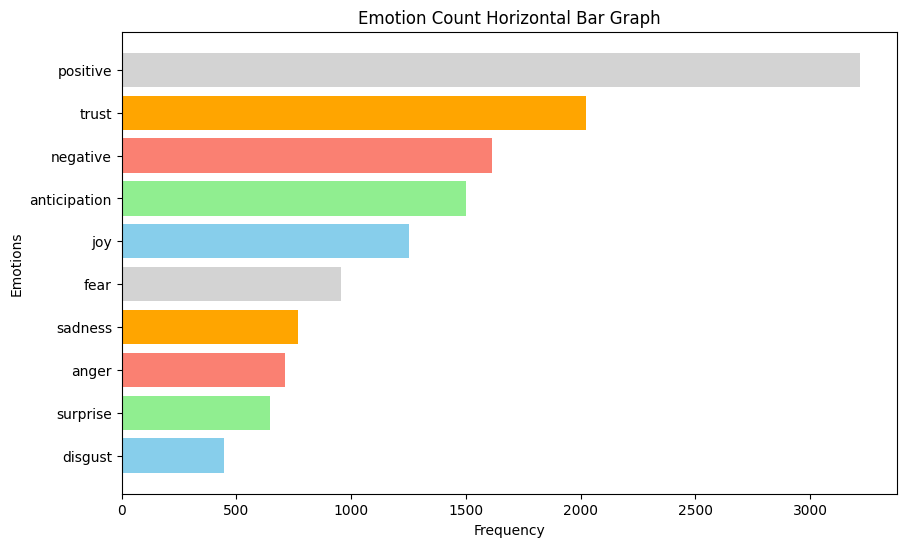

In [252]:
# Sort the dictionary by count
sorted_emotion_count = dict(sorted(emotion_count.items(), key=lambda item: item[1]))

# Extract sorted keys and values
emotions = list(sorted_emotion_count.keys())
counts = list(sorted_emotion_count.values())

# Define colors for each bar
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'lightgrey']

# Create the horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(emotions, counts, color=colors)
plt.xlabel('Frequency')
plt.ylabel('Emotions')
plt.title('Emotion Count Horizontal Bar Graph')
plt.show()

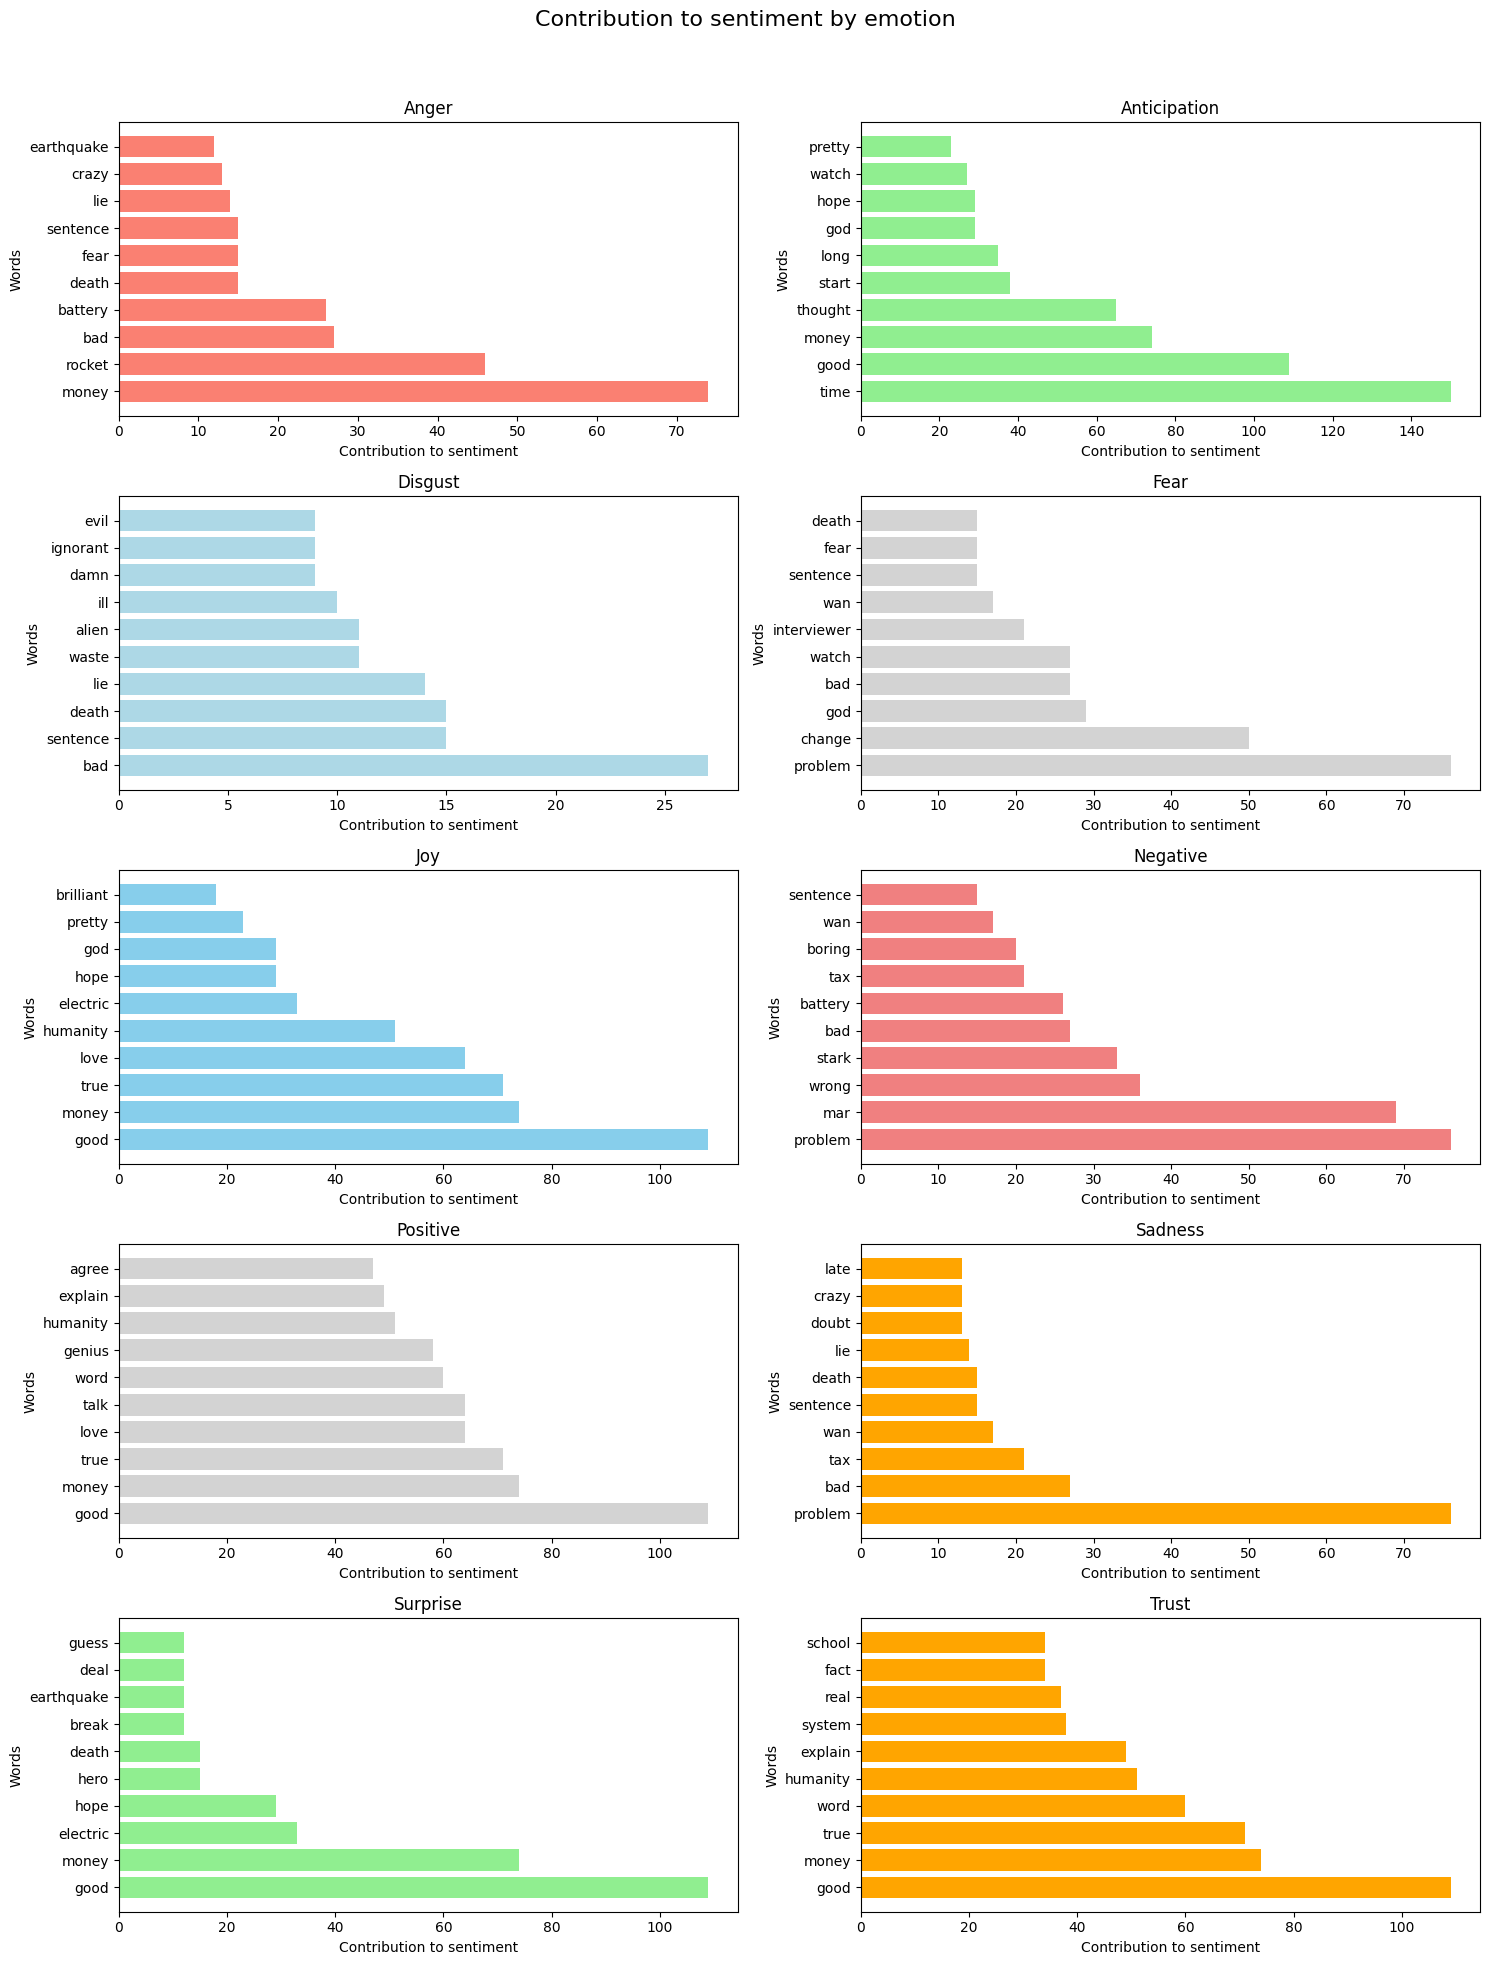

In [253]:
# Load NRC Emotion Lexicon
lexicon = {}
emotions = ["anger", "anticipation", "disgust", "fear", "joy", "negative", "positive", "sadness", "surprise", "trust"]

for emotion in emotions:
    with open(f'nrc_emotion_lexicon/{emotion}-NRC-Emotion-Lexicon.txt', 'r') as file:
        words = [line.strip().split()[0] for line in file.readlines() if line.strip().split()[1] == '1']
        lexicon[emotion] = words

def map_text_to_emotion(text):
    emotion_counter = {emotion: 0 for emotion in emotions}
    tokens = text.split()
    for word in tokens:
        for emotion in emotions:
            if word in lexicon[emotion]:
                emotion_counter[emotion] += 1
    return emotion_counter

# Applying the mapping function to the cleaned text
emotion_count = map_text_to_emotion(clean_text)

# Define colors for each emotion
emotion_colors = {
    "anger": "salmon",
    "anticipation": "lightgreen",
    "disgust": "lightblue",
    "fear": "lightgrey",
    "joy": "skyblue",
    "negative": "lightcoral",
    "positive": "lightgrey",
    "sadness": "orange",
    "surprise": "lightgreen",
    "trust": "orange"
}

# Create individual bar plots for each emotion
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
fig.suptitle('Contribution to sentiment by emotion', fontsize=16)

for ax, (emotion, count) in zip(axs.flatten(), emotion_count.items()):
    words = lexicon[emotion]
    word_counts = [clean_text.split().count(word) for word in words]
    word_count_dict = dict(zip(words, word_counts))
    sorted_words = dict(sorted(word_count_dict.items(), key=lambda item: item[1], reverse=True)[:10])
    
    ax.barh(list(sorted_words.keys()), list(sorted_words.values()), color=emotion_colors[emotion])
    ax.set_title(emotion.capitalize())
    ax.set_xlabel('Contribution to sentiment')
    ax.set_ylabel('Words')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3.2 Vader Analysis

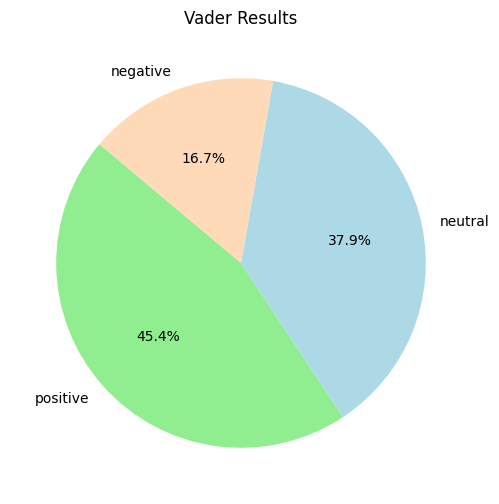

In [254]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate VADER sentiment scores
def vader_sentiment_analysis(text):
    return analyzer.polarity_scores(text)

# Apply VADER sentiment analysis to each comment
comments['Sentiment'] = comments['Comment'].apply(lambda x: vader_sentiment_analysis(str(x)))

# Extract compound scores for simplicity
comments['Compound'] = comments['Sentiment'].apply(lambda x: x['compound'])

# Categorize sentiments
def categorize_sentiment(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

comments['Sentiment Category'] = comments['Compound'].apply(categorize_sentiment)

# Count the occurrences of each sentiment category
sentiment_counts = comments['Sentiment Category'].value_counts()

# Plot the sentiment distribution as a pie chart
plt.figure(figsize=(8, 6))
colors = ['lightgreen', 'lightblue', 'peachpuff']
sentiment_counts.plot(kind='pie', colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Vader Results')
plt.ylabel('')  # Hide the y-label
plt.show()


### 3.2.1 Vader Time-series Analysis

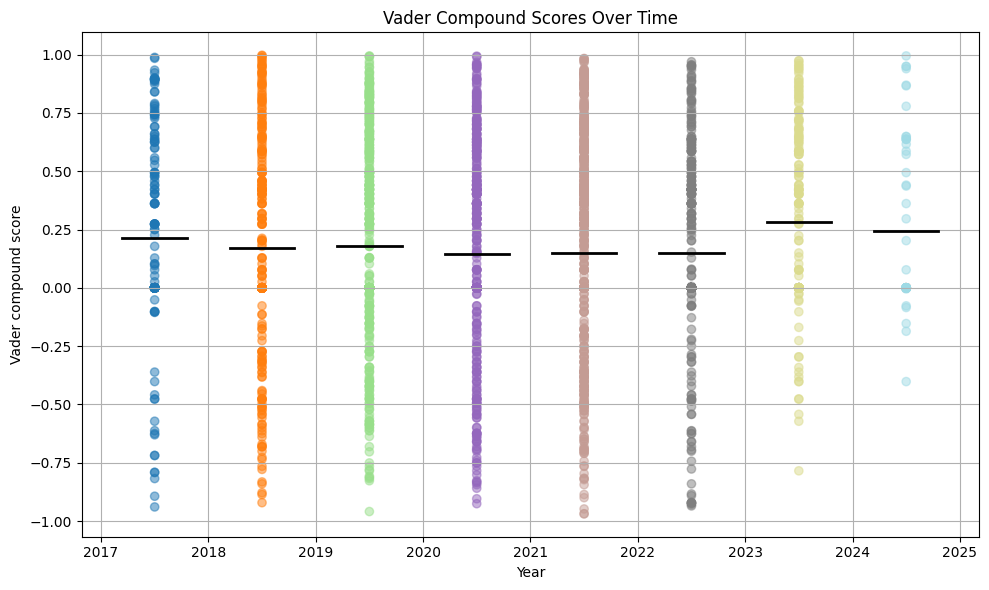

In [255]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply VADER Sentiment Analysis on the dataset
comments['compound'] = comments['Comment'].apply(lambda x: analyzer.polarity_scores(x)['compound'] if isinstance(x, str) else 0)
comments['neg'] = comments['Comment'].apply(lambda x: analyzer.polarity_scores(x)['neg'] if isinstance(x, str) else 0)
comments['neu'] = comments['Comment'].apply(lambda x: analyzer.polarity_scores(x)['neu'] if isinstance(x, str) else 0)
comments['pos'] = comments['Comment'].apply(lambda x: analyzer.polarity_scores(x)['pos'] if isinstance(x, str) else 0)

# Ensure the sentiment score columns are numeric
comments[['compound', 'neg', 'neu', 'pos']] = comments[['compound', 'neg', 'neu', 'pos']].apply(pd.to_numeric, errors='coerce')

# Drop rows with None in 'Year'
comments = comments.dropna(subset=['Year'])

# Sort the DataFrame by 'Year'
comments = comments.sort_values(by='Year')

# Calculate mean compound scores for each year
yearly_mean = comments.groupby('Year').mean(numeric_only=True)

# Plot the VADER results with 'Year' on the x-axis using scatter plots
plt.figure(figsize=(10, 6))

# Scatter plot for compound scores
plt.scatter(comments['Year'], comments['compound'], alpha=0.5, c=comments['Year'], cmap='tab20', label='Compound')

# Plot short black lines for the mean compound scores
for year in yearly_mean.index:
    mean_compound = yearly_mean.loc[year, 'compound']
    plt.plot([year - 0.3, year + 0.3], [mean_compound, mean_compound], color='black', linestyle='-', linewidth=2)

plt.title('Vader Compound Scores Over Time')
plt.xlabel('Year')
plt.ylabel('Vader compound score')
plt.grid(True)
plt.tight_layout()
plt.show()

## 3.3 TextBlob Analysis

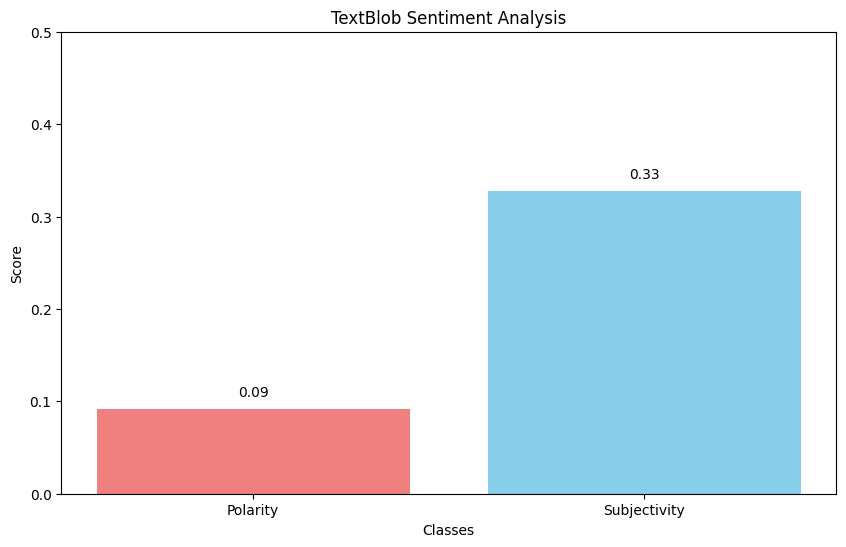

In [256]:
def textblob_sentiment_analysis(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply TextBlob sentiment analysis to each comment
comments['Polarity'], comments['Subjectivity'] = zip(*comments['Comment'].apply(lambda x: textblob_sentiment_analysis(str(x))))

# Calculate mean polarity and subjectivity
mean_polarity = comments['Polarity'].mean()
mean_subjectivity = comments['Subjectivity'].mean()

# Plot the mean polarity and subjectivity
plt.figure(figsize=(10, 6))
classes = ['Polarity', 'Subjectivity']
scores = [mean_polarity, mean_subjectivity]
colors = ['lightcoral', 'skyblue']

bars = plt.bar(classes, scores, color=colors)

# Add text annotations to the bars
for bar, score in zip(bars, scores):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom')

plt.title('TextBlob Sentiment Analysis')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim(0, 0.5)
plt.show()

### 3.3.1 TextBlob Analysis Overtime

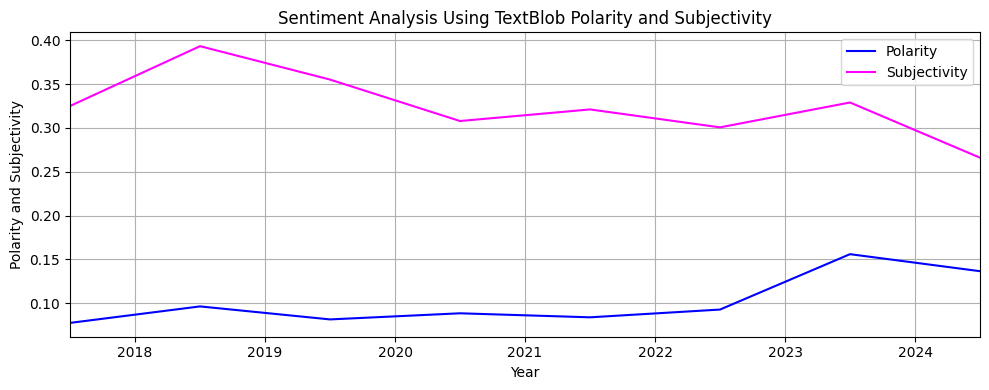

In [257]:
# Apply TextBlob Sentiment Analysis on the dataset
comments['polarity'] = comments['Comment'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
comments['subjectivity'] = comments['Comment'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0)

# Sort the DataFrame by 'Year'
comments = comments.sort_values(by='Year')

# Group by year and calculate mean scores
yearly_sentiment = comments.groupby('Year').mean(numeric_only=True)

# Plot the TextBlob results with 'Year' on the x-axis using line plots
plt.figure(figsize=(10, 4))

# Moving average sentiment scores from 2023 onwards
plt.plot(yearly_sentiment.index, yearly_sentiment['polarity'], label='Polarity', color='blue')
plt.plot(yearly_sentiment.index, yearly_sentiment['subjectivity'], label='Subjectivity', color='magenta')

plt.title('Sentiment Analysis Using TextBlob Polarity and Subjectivity')
plt.xlabel('Year')
plt.ylabel('Polarity and Subjectivity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim((2017.5, 2024.5))
plt.show()

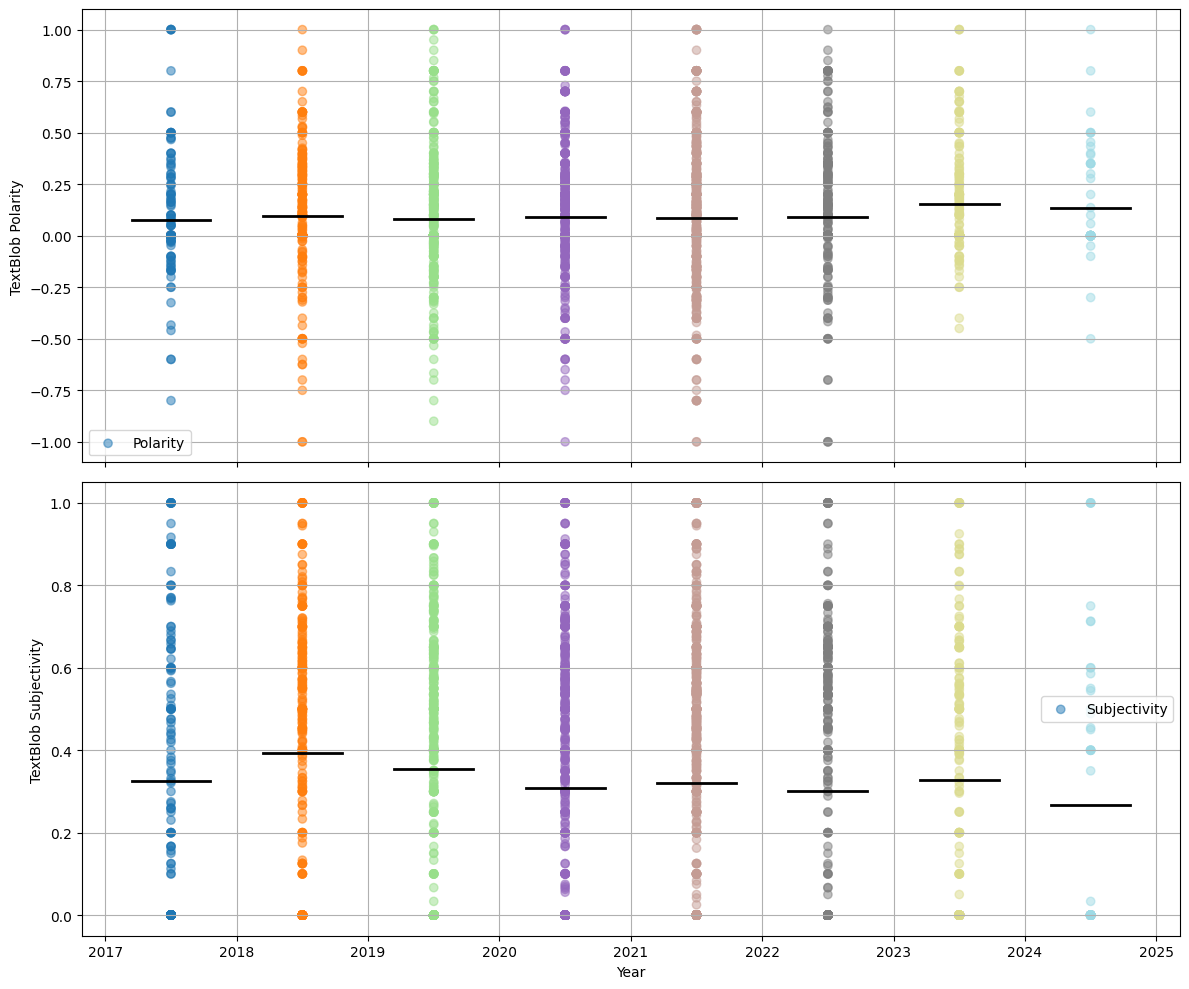

In [258]:
# Apply TextBlob Sentiment analysis on the dataset
comments['polarity'] = comments['Comment'].apply(lambda x: TextBlob(x).sentiment.polarity if isinstance(x, str) else 0)
comments['subjectivity'] = comments['Comment'].apply(lambda x: TextBlob(x).sentiment.subjectivity if isinstance(x, str) else 0)

# Drop rows with None in 'Year'
comments = comments.dropna(subset=['Year'])

# Sort the DataFrame by 'Year'
comments = comments.sort_values(by='Year')

# Calculate mean polarity and subjectivity for each year
yearly_mean = comments.groupby('Year').mean(numeric_only=True)

# Plot the TextBlob results with 'Year' on the x-axis using scatter plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

# Plot polarity
axes[0].scatter(comments['Year'], comments['polarity'], alpha=0.5, c=comments['Year'], cmap='tab20', label='Polarity')

for year in yearly_mean.index:
    mean_polarity = yearly_mean.loc[year, 'polarity']
    axes[0].plot([year - 0.3, year + 0.3], [mean_polarity, mean_polarity], color='black', linestyle='-', linewidth=2)

axes[0].set_ylabel('TextBlob Polarity')
axes[0].legend()
axes[0].grid(True)

# Plot subjectivity
axes[1].scatter(comments['Year'], comments['subjectivity'], alpha=0.5, c=comments['Year'], cmap='tab20', label='Subjectivity')

for year in yearly_mean.index:
    mean_subjectivity = yearly_mean.loc[year, 'subjectivity']
    axes[1].plot([year - 0.3, year + 0.3], [mean_subjectivity, mean_subjectivity], color='black', linestyle='-', linewidth=2)

axes[1].set_xlabel('Year')
axes[1].set_ylabel('TextBlob Subjectivity')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### 3.4 ML supported approach (Logistic Regression )

Accuracy: 0.7121212121212122
              precision    recall  f1-score   support

           0       0.71      0.72      0.71        99
           1       0.71      0.71      0.71        99

    accuracy                           0.71       198
   macro avg       0.71      0.71      0.71       198
weighted avg       0.71      0.71      0.71       198

[1, 1]


c:\Users\Thy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Thy\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


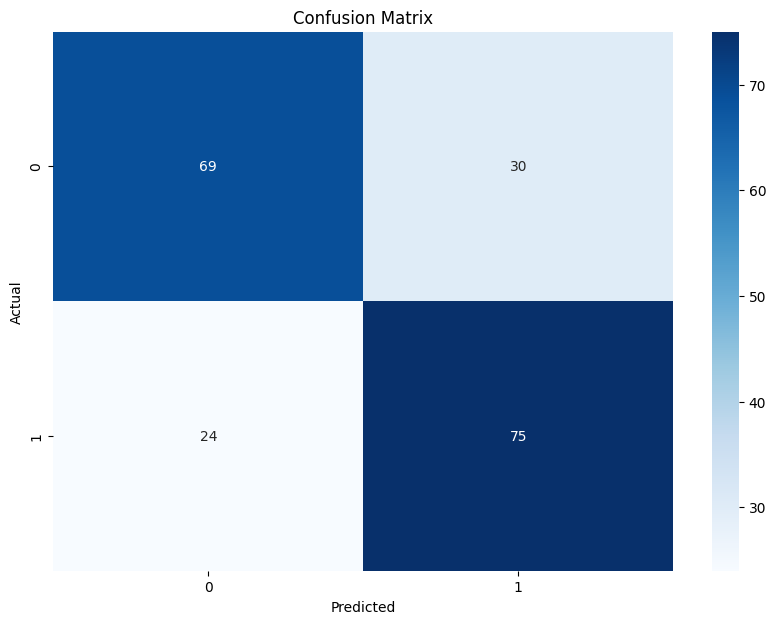

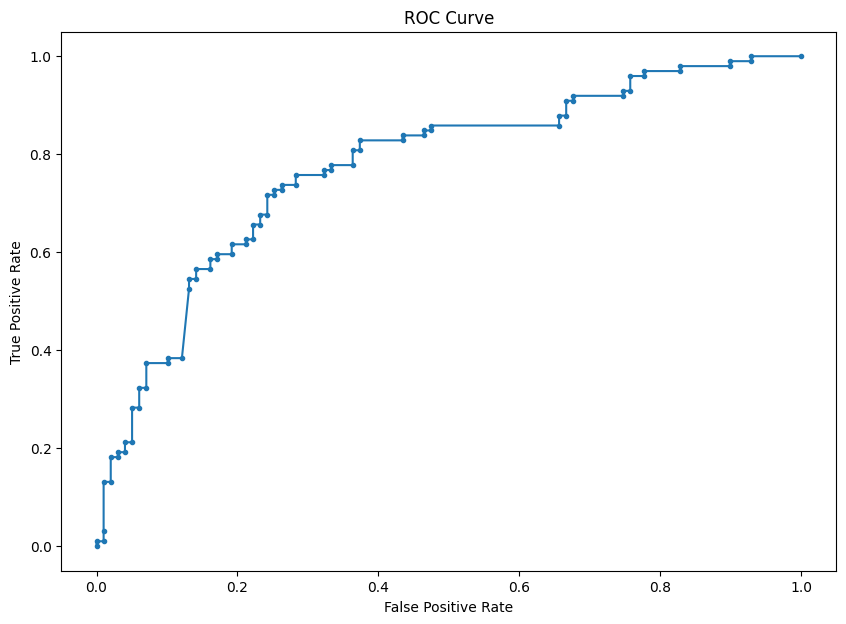

In [271]:
# Initialize VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    if isinstance(text, str):
        score = sid.polarity_scores(text)['compound']
        return 1 if score >= 0 else 0  # 1 for positive, 0 for negative
    return 0

# Apply sentiment scoring
clean_comments['sentiment'] = clean_comments['Comment'].apply(get_sentiment_score)

# Drop rows with NaN values in 'cleaned_comments'
clean_comments.dropna(subset=['Comment'], inplace=True)

# Split the dataset into majority and minority classes
df_majority = clean_comments[clean_comments.sentiment == 1]
df_minority = clean_comments[clean_comments.sentiment == 0]

# Downsample the majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,  # sample without replacement
                                   n_samples=len(df_minority),  # to match minority class
                                   random_state=42)  # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_minority, df_majority_downsampled])

# Split the balanced dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Comment'], df_balanced['sentiment'], test_size=0.2, random_state=42)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Logistic Regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_tfidf)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

# Define a function to predict sentiment using the trained model
def predict_sentiment(text, vectorizer, model):
    cleaned_text = clean_text(text)
    text_tfidf = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_tfidf)
    return prediction[0]

# Test the function with new comments
new_comments = ["This video is amazing!", "I didn't like the presentation."]
predictions = [predict_sentiment(comment, tfidf_vectorizer, log_reg) for comment in new_comments]

print(predictions)

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],  # l1 lasso, l2 ridge
    'solver': ['liblinear']   # liblinear is good for small datasets
}

# Initialize GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Train the model
grid_search.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = grid_search.predict(X_test_tfidf)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_prob = grid_search.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()